In [1]:
#AUTOCORRELATION
import numpy as np
from plot_lib import set_default, show_scatterplot, plot_bases, plot_data
from matplotlib.pyplot import plot, title, axis

from scipy.signal import chirp, square, sawtooth, sweep_poly, butter, lfilter, freqz, decimate

In [2]:
set_default()

In [3]:
# PARAMETERS

# seconds
duration = 10.0
# 44.1 kHz
sampleRate = 44100
# total number of samples over the entire clip
samples = int(sampleRate * duration)

t = np.arange(samples) / sampleRate

In [4]:
def clamp(val, mi, ma):
    return max(min(val, ma), mi)

In [5]:
"""
this convenience function is based on:

https://soledadpenades.com/2009/10/29
       /fastest-way-to-generate-wav-files-in-python-using-the-wave-module/
"""

import random, struct
import wave

def writeWav(filename, signal):
    
    # create a wav file writer stream
    noise_output = wave.open(filename, 'w')
    noise_output.setparams((2, 2, sampleRate, 0, 'NONE', 'not compressed'))

    values = []
    noise = []

    for i in range(0, samples):
    #     value = random.randint(-32767, 32767)
        #clamp val between -1 and 1
        v = clamp(signal[i],-1.,1.)
        value = int(v * 32767)

        packed_value = struct.pack('h', value)
        values.append(packed_value)
        values.append(packed_value)
        noise.append(v)

    value_str = b"".join(values)
    noise_output.writeframes(value_str)

    noise_output.close()

    

In [6]:
# swell from middle C over an octave
signal = chirp(t, 261.0, t[-1], 522.0,  method='quadratic', vertex_zero=False)

signal *= (0.5 + 0.5 * np.sin(3.0 * np.pi * 2.0 * t))

writeWav("chirp.wav", signal)

In [7]:
# # swell from middle C over an octave
# signal = chirp(t, 261.0, t[-1], 522.0)

# signal = square(2 * np.pi * 30 * t, duty=(signal + 1)/2)

# writeWav("square.wav", signal)

In [8]:
# # swell from middle C over an octave
# # signal = chirp(t, 261.0, t[-1], 522.0)
# signal = sawtooth(2 * np.pi * 30 * t)

# writeWav("sawtooth.wav", signal)

In [9]:
# # swell from middle C over an octave
# signal = chirp(t, 261.0, t[-1], 522.0)

# p = np.poly1d([0.025, -0.36, 1.25, 2.0])
# signal = sweep_poly(2 * np.pi * 30 * t, p)

# writeWav("sweep.wav", signal)

In [10]:
# https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 7.667  # desired cutoff frequency of the filter, Hz

# # Get the filter coefficients so we can check its frequency response.
# b, a = butter_lowpass(cutoff, fs, order)

# # Plot the frequency response.
# w, h = freqz(b, a, worN=8000)

# y = butter_lowpass_filter(autocorr, cutoff, fs, order)

# plot(t, np.log(y))

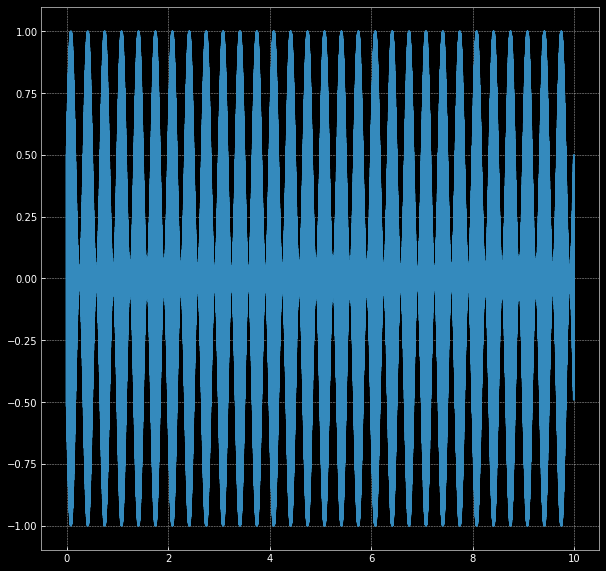

In [11]:
#clean signal
plot(t, signal)

# rms_envelope = np.sqrt(np.mean(signal**2))

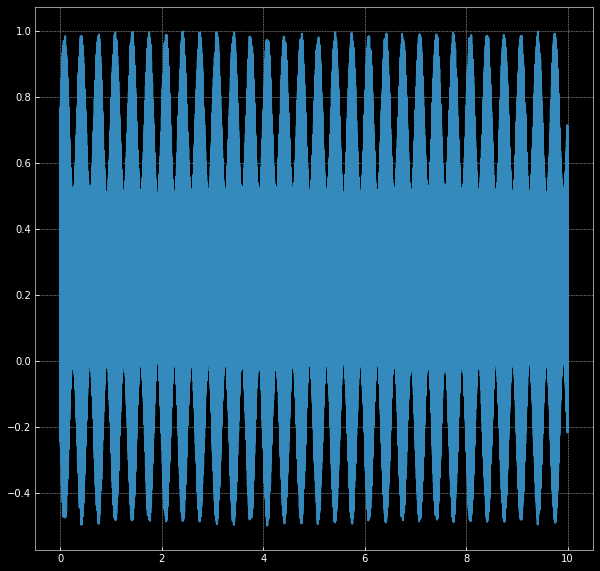

In [12]:
# add noise
noisy_signal = 0.5 * signal + .5 * np.random.sample(samples)
plot(t, noisy_signal)

c:\users\shift_000\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


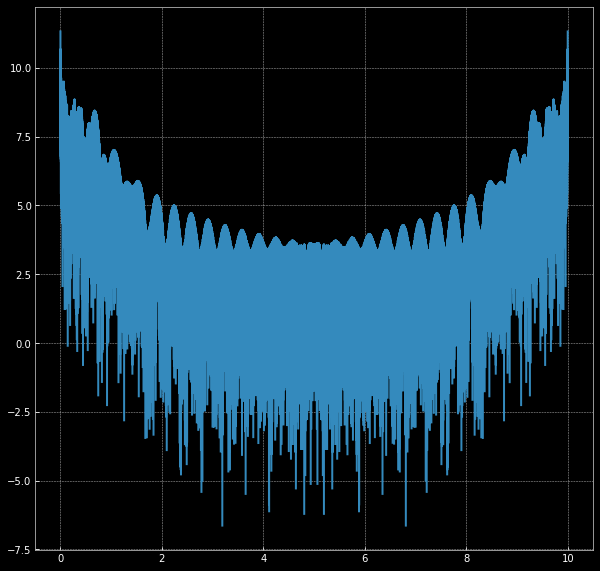

In [13]:
# # autocorrelation of clean signal

# time to frequency domain, via fast fourier transform
freqs = np.fft.rfft(signal)

# multiply frequencies by complex conjugate of the frequencies and inverse fft
# to recover the autocorrelation amplitude in time domain

# this is almost equivalent to convolution
autocorr = np.fft.irfft(freqs * np.conj(freqs))

# scale by log to normalize
plot(t, np.log(autocorr))

The signals peaks at the beginning and end, which makes sense, on account of the frequency starting at C, and ending on the next octave, where the two frequencies reasonate.

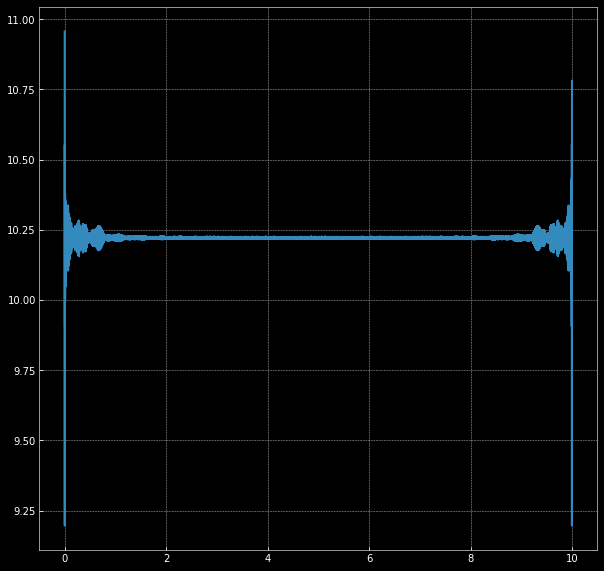

In [14]:
# # autocorrelation of noisy signal
freqs = np.fft.rfft(noisy_signal)
autocorr = np.fft.irfft(freqs * np.conj(freqs))

# scale by log to normalize
plot(t, np.log(autocorr))

You can see the correlation collapse more quickly as you move away from the C oscillations on the noisy signal plotted above

c:\users\shift_000\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


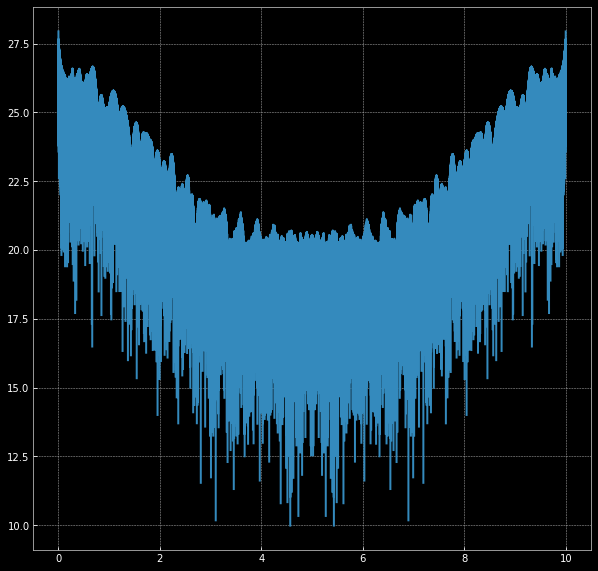

In [16]:
# cyclic autocorrelation
freqs = np.fft.rfft(signal)
tmp = freqs * np.conj(freqs)
# do it again
tmp = tmp * np.conj(tmp)
autocorr = np.fft.irfft(tmp)

plot(t, np.log(autocorr))

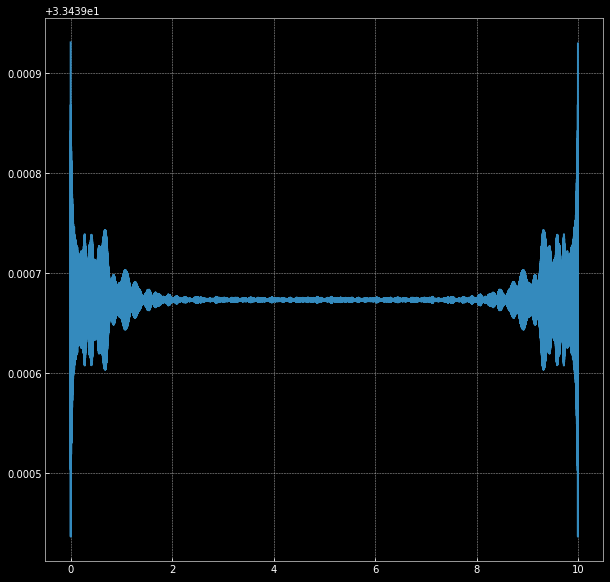

In [18]:
# cyclic autocorrelation of noisy

freqs = np.fft.rfft(noisy_signal)
tmp = freqs * np.conj(freqs)
tmp = tmp * np.conj(tmp)
autocorr = np.fft.irfft(tmp)

plot(t, np.log(autocorr))

Taking this further you can imagine tempo detection, or other periodicity detection tasks - find the peaks of sliding windows, etc, use with HMMs (or perhaps RNNs) for pitch and chord detection algorithms -- bonus points for query by humming

In [19]:
def onsetDetection():
    pass

def tempoDetection():
    pass

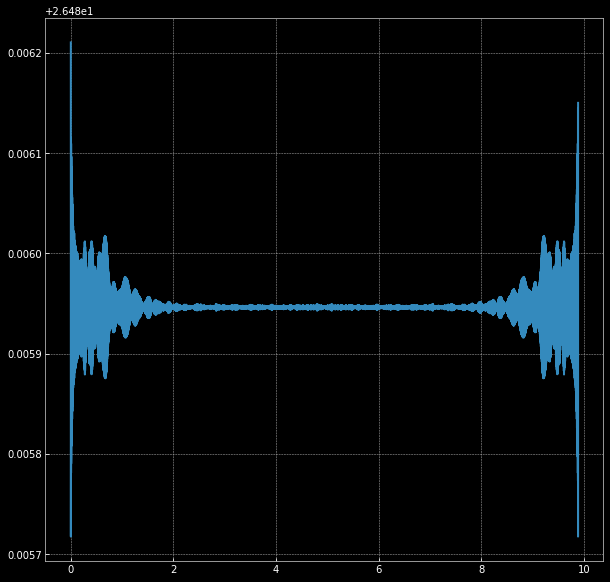

In [31]:
tmp_signal = decimate(noisy_signal, 10)
tmpt = decimate(t, 10)
# tmp_signal = decimate(tmp_signal, 10)
# tmpt = decimate(tmpt, 10)

# plot(tmpt, tmp_signal)

freqs = np.fft.rfft(tmp_signal)
tmp = freqs * np.conj(freqs)
tmp = tmp * np.conj(tmp)
autocorr = np.fft.irfft(tmp)

plot(tmpt, np.log(autocorr))